### A notebook to extract and present current status regarding BiGG and Rhea

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from venny4py.venny4py import *
import networkx as nx
import requests
import io
from pyvis.network import Network
from collections import Counter
import re
import ast

In [35]:
bigg = pd.read_csv("bigg_transported_mets.tsv", sep="t", header=None, skiprows=[0], usecols=[1,2,3])
rhea = pd.read_csv("rheaTransports.tsv", sep="t", header=None, skiprows=[0], usecols=[1,3,4,5,6])
bigg.columns = ["bigg_id", "ID", "rhea"]
rhea.columns = ["rid", "cid", "ec", "accession", "name"]
bigg["rhea"] = bigg["rhea"].str.replace(r'(?i)chebi', 'CHEBI', regex=True)

In [36]:
common_chebi = pd.merge(bigg, rhea, left_on="rhea", right_on="accession", how="inner")
common_chebi[["bigg_id", "ID", "rhea", "ec", "name"]].head()

,bigg_id,ID,rhea,ec,name
0,h,MNXM1,CHEBI:15378,"('7.1.1.9',)",H(+)
1,h,MNXM1,CHEBI:15378,"('7.1.1.8',)",H(+)
2,h,MNXM1,CHEBI:15378,"('7.1.3.1',)",H(+)
3,h,MNXM1,CHEBI:15378,"('7.1.2.1',)",H(+)
4,h,MNXM1,CHEBI:15378,"('7.2.4.3',)",H(+)


An overview of the distribution of EC numbers from the Rhea data

C:\Users\landr\AppData\Local\Temp\ipykernel_35564\569167022.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rhea = rhea[~rhea["ec"].str.contains(r"^(nan|nan,|\[nan\])$", case=False, na=False)]


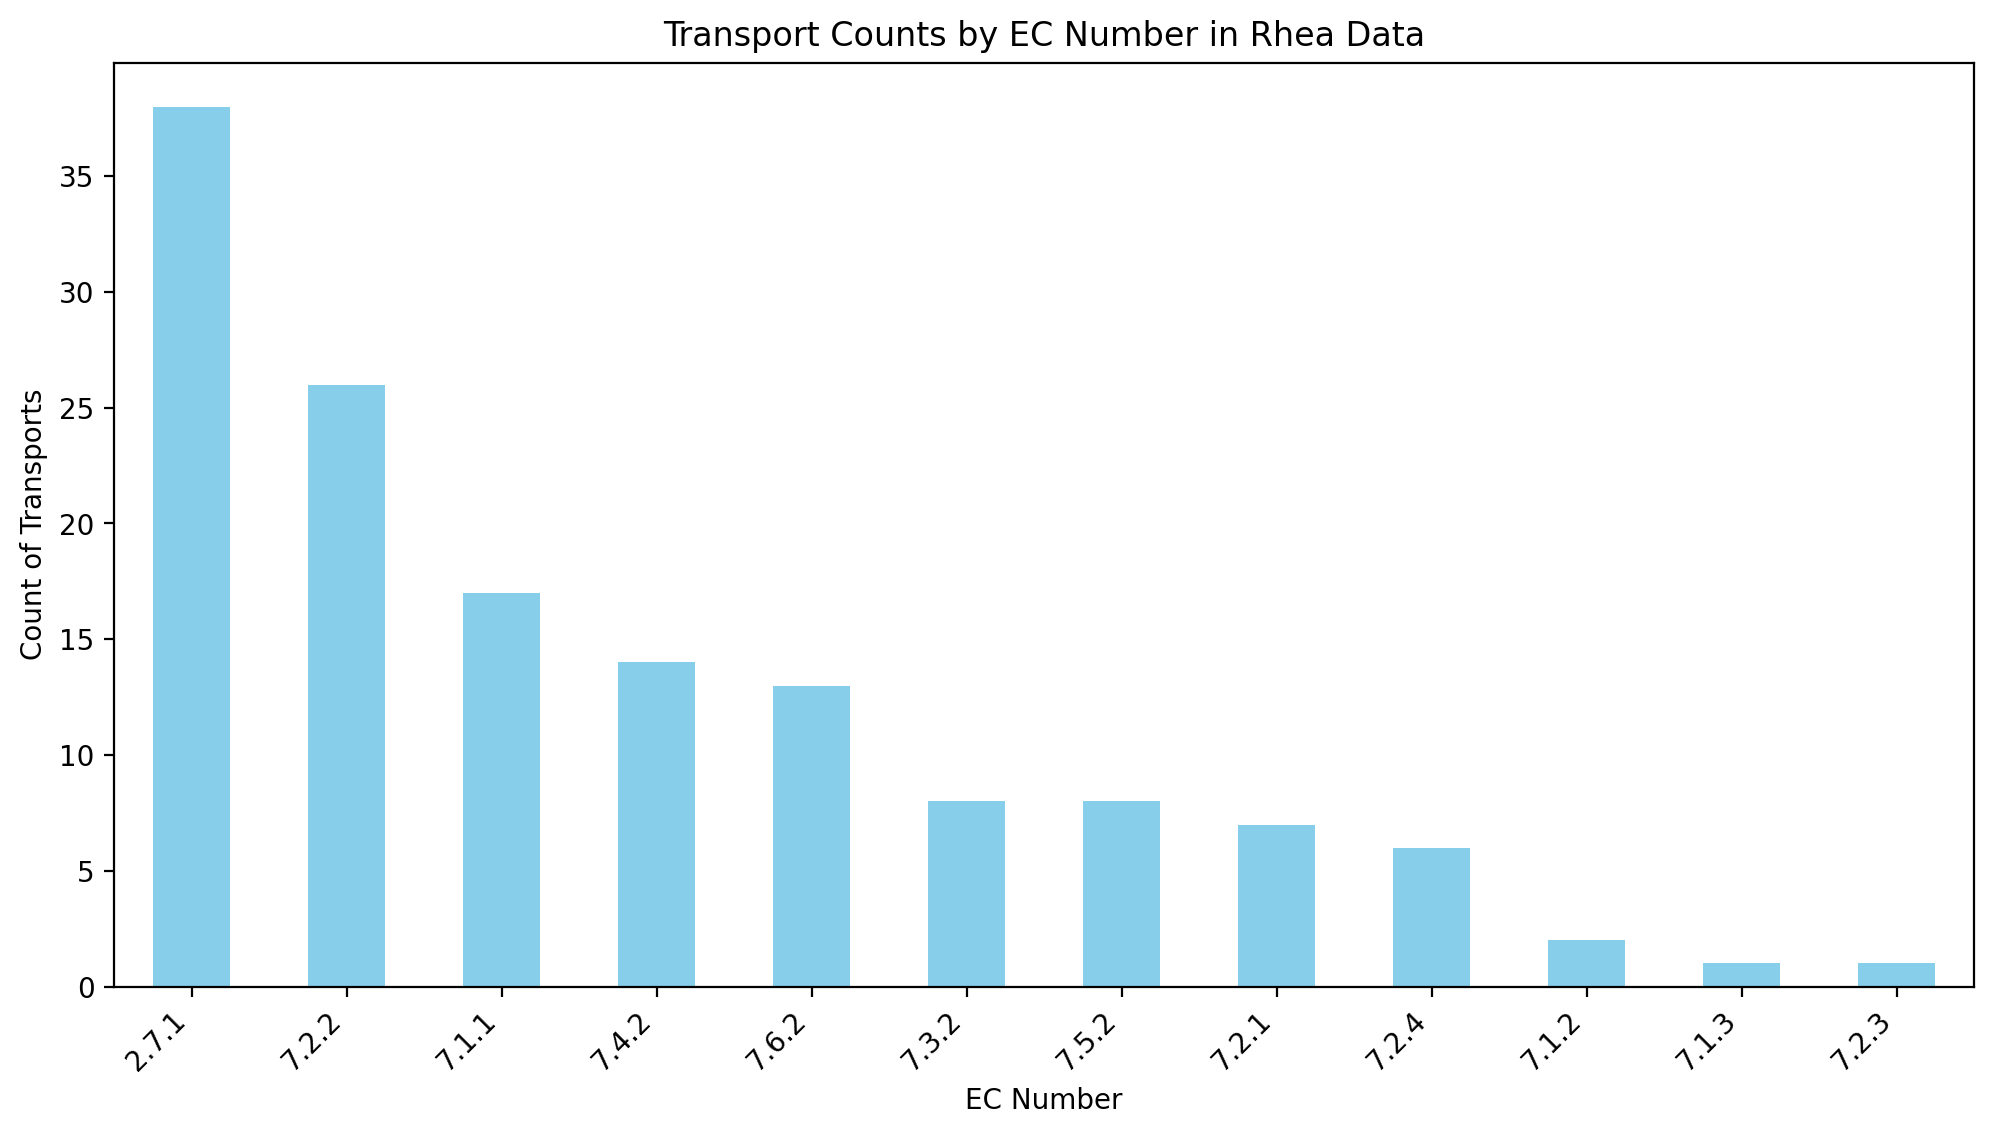

In [37]:
rhea = rhea[~rhea["ec"].str.contains(r"^(nan|nan,|\[nan\])$", case=False, na=False)]
rhea["ec"] = rhea["ec"].str.replace(r"[()']", "", regex=True)
rhea["ec_group"] = rhea["ec"].str.extract(r"^(\d+\.\d+\.\d+)")[0]
rhea = rhea.dropna(subset=["ec_group"])

ec_counts = rhea["ec_group"].value_counts()

plt.figure(figsize=(12, 6))
ec_counts.plot(kind="bar", color="skyblue")
plt.xlabel("EC Number")
plt.ylabel("Count of Transports")
plt.title("Transport Counts by EC Number in Rhea Data")
plt.xticks(rotation=45, ha="right")
plt.show()

Overlap between Rhea and BiGG

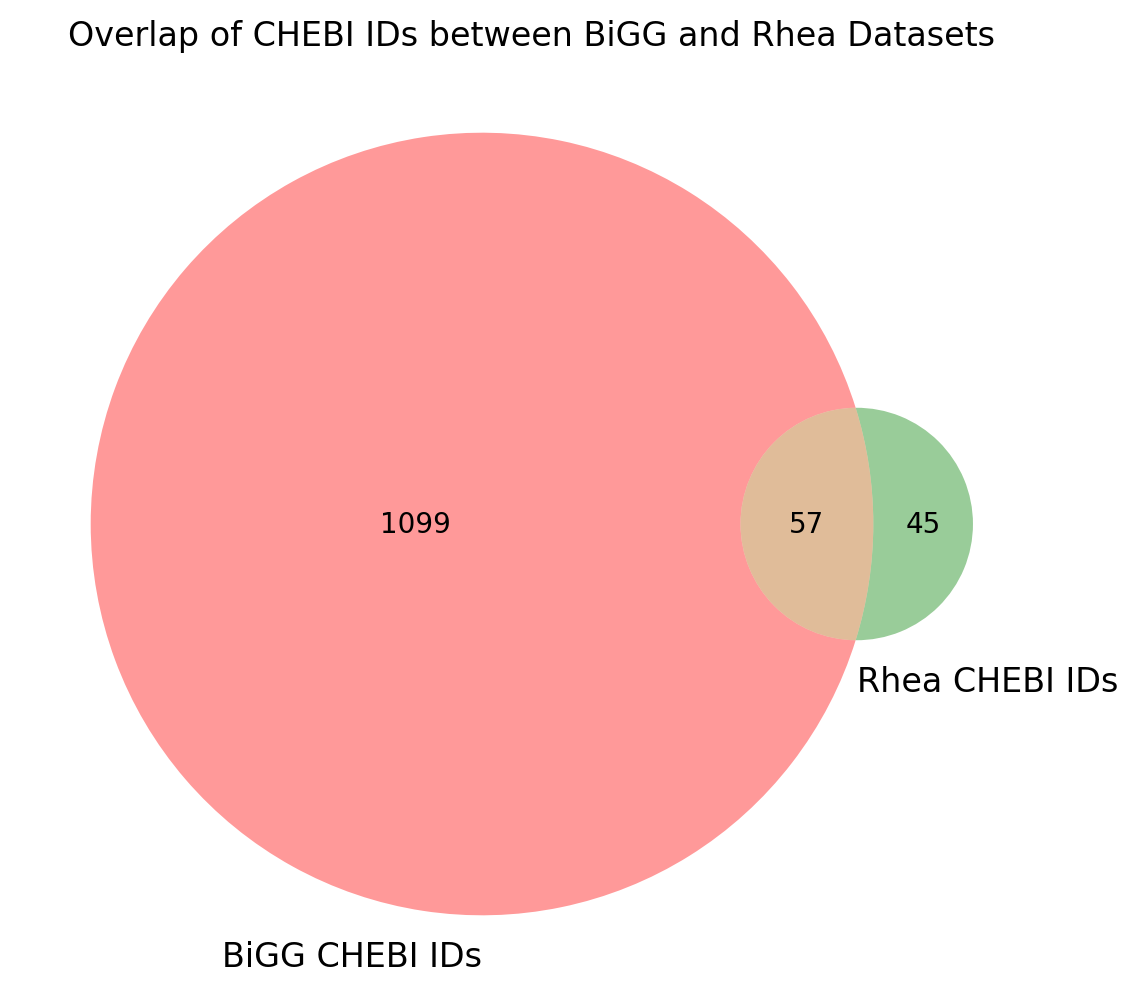

In [38]:
bigg_chebi_ids = set(bigg["rhea"].unique())
rhea_chebi_ids = set(rhea["accession"].unique())

plt.figure(figsize=(8, 6))
venn = venn2([bigg_chebi_ids, rhea_chebi_ids], ("BiGG CHEBI IDs", "Rhea CHEBI IDs"))
plt.title("Overlap of CHEBI IDs between BiGG and Rhea Datasets")
plt.show()

Obtaining data from Rhea online

In [39]:
RHEA_URL = "https://www.rhea-db.org/rhea?"
query = "transport:yes"
response = requests.get(RHEA_URL, params={"query": query, "format": "tsv", "columns": "rhea-id,ec,equation,go,chebi-id"})
df = pd.read_csv(io.StringIO(response.text), sep="\t")
df

,Reaction identifier,EC number,Equation,Gene Ontology,ChEBI identifier
0,RHEA:23120,EC:7.4.2.9,a dipeptide(out) + ATP + H2O = a dipeptide(in)...,NaN,CHEBI:90799;CHEBI:30616;CHEBI:15377;CHEBI:4562...
1,RHEA:23972,EC:7.2.4.5,(2E)-glutaconyl-CoA + Na(+)(in) + H(+) = (2E)-...,GO:0018801 glutaconyl-CoA decarboxylase activity,CHEBI:57353;CHEBI:29101;CHEBI:15378;CHEBI:5733...
2,RHEA:24440,EC:7.3.2.1,phosphate(out) + ATP + H2O = ADP + 2 phosphate...,GO:0015415 ATPase-coupled phosphate ion transm...,CHEBI:43474;CHEBI:30616;CHEBI:15377;CHEBI:4562...
3,RHEA:25792,EC:7.2.2.8,Cu(+)(in) + ATP + H2O = Cu(+)(out) + ADP + pho...,GO:0140581 P-type monovalent copper transporte...,CHEBI:49552;CHEBI:30616;CHEBI:15377;CHEBI:4562...
4,RHEA:27814,NaN,acetate(in) + Na(+)(in) = acetate(out) + Na(+)...,NaN,CHEBI:30089;CHEBI:29101
...,...,...,...,...,...
1497,RHEA:21668,EC:7.6.2.10,sn-glycerol 3-phosphate(out) + ATP + H2O = sn-...,GO:0015430 ABC-type glycerol-3-phosphate trans...,CHEBI:57597;CHEBI:30616;CHEBI:15377;CHEBI:4562...
1498,RHEA:22020,EC:7.3.2.5,molybdate(out) + ATP + H2O = molybdate(in) + A...,GO:0015412 ABC-type molybdate transporter acti...,CHEBI:36264;CHEBI:30616;CHEBI:15377;CHEBI:4562...
1499,RHEA:22044,EC:7.2.2.19,K(+)(out) + ATP + H2O + H(+)(in) = K(+)(in) + ...,GO:0008900 P-type potassium:proton transporter...,CHEBI:29103;CHEBI:30616;CHEBI:15377;CHEBI:1537...
1500,RHEA:22132,EC:7.5.2.1,D-maltose(out) + ATP + H2O = D-maltose(in) + A...,GO:0015423 ABC-type maltose transporter activity,CHEBI:17306;CHEBI:30616;CHEBI:15377;CHEBI:4562...


Building a network on substrates and their corresponding transporters

In [40]:
net = Network(directed=True, height="98vh", width="99vw", cdn_resources="remote")

added_nodes = set()
df_filtered = df.dropna(subset=["EC number"])

node_degrees = Counter()

def clean_node_name(node_name):
    cleaned_name = re.sub(r'^\d+\s+', '', node_name)
    cleaned_name = re.sub(r'^n\s+', '', cleaned_name, flags=re.IGNORECASE)
    cleaned_name = re.sub(r'\s*\((in|out)\)$', '', cleaned_name, flags=re.IGNORECASE)
    return cleaned_name

for i, row in df_filtered.iterrows():
    reaction = row["Reaction identifier"]
    net.add_node(reaction, shape="box", label=row["EC number"], color="lightgreen")
    
    left, right = row["Equation"].split(" = ")
    
    for compound in left.split(" + "):
        compound = clean_node_name(compound)
        if compound not in added_nodes:
            net.add_node(compound, physics=False)
            added_nodes.add(compound)
        net.add_edge(compound, reaction, color="coral", physics=False)
        node_degrees[compound] += 1
        node_degrees[reaction] += 1
        
    for compound in right.split(" + "):
        compound = clean_node_name(compound)
        if compound not in added_nodes:
            net.add_node(compound, physics=False)
            added_nodes.add(compound)
        net.add_edge(reaction, compound, color="coral", physics=False)
        node_degrees[compound] += 1
        node_degrees[reaction] += 1

for node, degree in node_degrees.items():
    net.get_node(node)["mass"] = 1 / degree
    if degree > 15: # The nodes with most edges had >15 nodes
        net.get_node(node)["color"] = "red"

net.set_options("""
{
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -3000,
      "centralGravity": 0.4,
      "springLength": 90,
      "springConstant": 0,
      "damping": 0.05,
      "avoidOverlap": 0
    },
    "minVelocity": 0.75,
    "maxVelocity": 50
  },
  "manipulation": {
    "enabled": false
  },
  "nodes": {
    "font": {
      "size": 12
    },
    "scaling": {
      "min": 10,
      "max": 30
    },
    "borderWidth": 0.5
  },
  "edges": {
    "width": 1,
    "smooth": {
      "enabled": true,
      "type": "continuous"
    }
  }
}
""")

net.write_html("network_rhea.html")

A secondary plot, now without the connection of edges for nodes previously added

In [63]:
net = Network(directed=True, height="98vh", width="99vw", cdn_resources="remote")

added_nodes = set()
df_filtered = df.dropna(subset=["EC number"])

node_degrees = Counter()

def clean_node_name(node_name):
    cleaned_name = re.sub(r'^\d+\s+', '', node_name)
    cleaned_name = re.sub(r'^n\s+', '', cleaned_name, flags=re.IGNORECASE)
    cleaned_name = re.sub(r'\s*\((in|out)\)$', '', cleaned_name, flags=re.IGNORECASE)
    return cleaned_name

for i, row in df_filtered.iterrows():
    reaction = row["Reaction identifier"]
    net.add_node(reaction, shape="box", label=row["EC number"], color="lightgreen")
    
    left, right = row["Equation"].split(" = ")
    
    for compound in left.split(" + "):
        compound = clean_node_name(compound)
        node_id = f"{compound}_left_{reaction}"
        # if compound not in added_nodes:
        net.add_node(node_id, label=compound, physics=False)
        # added_nodes.add(compound)
        net.add_edge(node_id, reaction, color="coral", physics=False)
        node_degrees[compound] += 1 # evt compound!!!!
        node_degrees[reaction] += 1
        
    for compound in right.split(" + "):
        compound = clean_node_name(compound)
        node_id = f"{compound}_left_{reaction}"
        # if compound not in added_nodes:
        net.add_node(node_id, label=compound, physics=False)
        # added_nodes.add(compound)
        net.add_edge(reaction, node_id, color="coral", physics=False)
        node_degrees[compound] += 1 # evt compound!!!!
        node_degrees[reaction] += 1

# for node, degree in node_degrees.items():
#     if degree > 15: # The nodes with most edges had >15 nodes
#         net.get_node(node)["color"] = "red"

for node_dict in net.nodes:
    node_id = node_dict["id"]
    node_data = net.get_node(node_id)
    if node_data["label"] in node_degrees and node_degrees[node_data["label"]] > 15:
        node_data["color"] = "red"
        



net.set_options("""
{
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -3000,
      "centralGravity": 0.4,
      "springLength": 90,
      "springConstant": 0,
      "damping": 0.05,
      "avoidOverlap": 0
    },
    "minVelocity": 0.75,
    "maxVelocity": 50
  },
  "manipulation": {
    "enabled": false
  },
  "nodes": {
    "font": {
      "size": 12
    },
    "scaling": {
      "min": 10,
      "max": 30
    },
    "borderWidth": 0.5
  },
  "edges": {
    "width": 1,
    "smooth": {
      "enabled": true,
      "type": "continuous"
    }
  }
}
""")

net.write_html("network_rhea_2.html")
node_degrees = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)#[:15]
node_degrees

[('H(+)', 102),
 ('H2O', 72),
 ('phosphate', 68),
 ('ATP', 65),
 ('ADP', 65),
 ('Na(+)', 24),
 ('N(pros)-phospho-L-histidyl-[protein]', 19),
 ('L-histidyl-[protein]', 19),
 ('RHEA:18353', 9),
 ('RHEA:22044', 8),
 ('RHEA:23120', 7),
 ('RHEA:25792', 7),
 ('RHEA:29767', 7),
 ('RHEA:29779', 7),
 ('RHEA:29791', 7),
 ('RHEA:29795', 7),
 ('RHEA:29799', 7),
 ('RHEA:29811', 7),
 ('RHEA:29871', 7),
 ('RHEA:29879', 7),
 ('RHEA:29883', 7),
 ('RHEA:29887', 7),
 ('RHEA:29899', 7),
 ('RHEA:29903', 7),
 ('RHEA:29995', 7),
 ('RHEA:29999', 7),
 ('RHEA:30007', 7),
 ('RHEA:33147', 7),
 ('RHEA:35027', 7),
 ('RHEA:46800', 7),
 ('RHEA:47748', 7),
 ('RHEA:58156', 7),
 ('RHEA:58492', 7),
 ('RHEA:58912', 7),
 ('RHEA:60156', 7),
 ('RHEA:61716', 7),
 ('RHEA:62576', 7),
 ('RHEA:62580', 7),
 ('RHEA:62584', 7),
 ('RHEA:65972', 7),
 ('RHEA:66820', 7),
 ('RHEA:76247', 7),
 ('RHEA:78459', 7),
 ('RHEA:10192', 7),
 ('RHEA:10260', 7),
 ('RHEA:10376', 7),
 ('RHEA:10848', 7),
 ('RHEA:11036', 7),
 ('RHEA:11348', 7),
 ('RHEA:

Get an overview of number of edges for each node

In [41]:
node_degrees

Counter({'a dipeptide': 2,
         'RHEA:23120': 7,
         'ATP': 65,
         'H2O': 72,
         'ADP': 65,
         'phosphate': 68,
         'H(+)': 102,
         '(2E)-glutaconyl-CoA': 1,
         'RHEA:23972': 6,
         'Na(+)': 24,
         '(2E)-butenoyl-CoA': 1,
         'CO2': 5,
         'RHEA:24440': 6,
         'Cu(+)': 2,
         'RHEA:25792': 7,
         'a ubiquinone': 4,
         'RHEA:29091': 6,
         'NADH': 5,
         'a ubiquinol': 4,
         'NAD(+)': 5,
         'D-methionine': 2,
         'RHEA:29767': 7,
         'L-methionine': 2,
         'RHEA:29779': 7,
         'glutathione': 2,
         'RHEA:29791': 7,
         'Zn(2+)': 4,
         'RHEA:29795': 7,
         'D-allose': 2,
         'RHEA:29799': 7,
         'thiamine': 2,
         'RHEA:29811': 7,
         'thiosulfate': 2,
         'RHEA:29871': 7,
         'L-arginine': 2,
         'RHEA:29879': 7,
         'L-ornithine': 2,
         'RHEA:29883': 7,
         'L-lysine': 2,
         'RHEA:29

Finding all neighbors to each node

In [11]:
rhea_to_ec = df.set_index("Reaction identifier")["EC number"].to_dict()

substrate_to_transporter_neighbors = {}
transporter_to_substrate_neighbors = {}

for node in net.nodes:
    cleaned_neighbors = {
        ec for neighbor in net.neighbors(node["id"])
        for ec in rhea_to_ec.get(neighbor, neighbor).split(";")
    }
    
    new_key = rhea_to_ec.get(node["id"], node["id"])
    
    if new_key.startswith("EC"):
        transporter_to_substrate_neighbors[new_key] = cleaned_neighbors
    else:
        substrate_to_transporter_neighbors[new_key] = cleaned_neighbors

Writing out all neighbors to ECs and substrates in seperate files

In [12]:
def write_dict_to_tsv(dictionary, file_name, node_title):
    rows = []
    for key, neighbors in dictionary.items():
        rows.append([key, ", ".join(neighbors)])

    df = pd.DataFrame(rows, columns=[node_title, "Neighbors"])
    df.to_csv(file_name, sep="\t", index=False)

write_dict_to_tsv(substrate_to_transporter_neighbors, "substrate_to_transporter_neighbors.tsv", "Substrate")
write_dict_to_tsv(transporter_to_substrate_neighbors, "transporter_to_substrate_neighbors.tsv", "EC number")

Overlap between Rhea (online) and BiGG

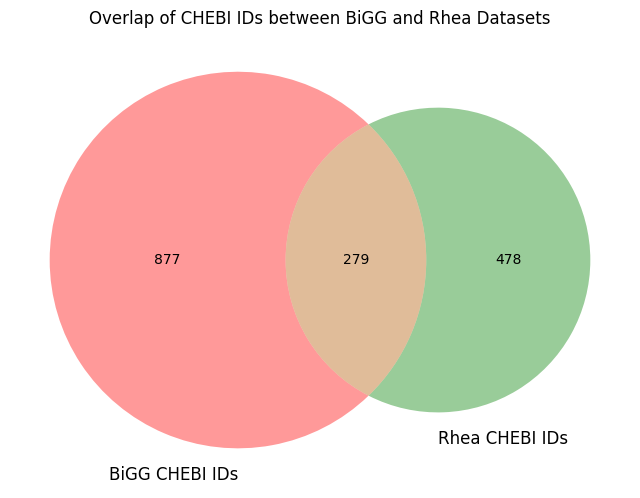

In [13]:
chebi_column = df["ChEBI identifier"]
all_chebi_ids = chebi_column.str.split(";").explode()
rhea_chebi_ids_2 = set(all_chebi_ids)

bigg_chebi_ids = set(bigg["rhea"].unique())

plt.figure(figsize=(8, 6))
venn = venn2([bigg_chebi_ids, rhea_chebi_ids_2], ("BiGG CHEBI IDs", "Rhea CHEBI IDs"))
plt.title("Overlap of CHEBI IDs between BiGG and Rhea Datasets")
plt.show()


Another try on obtaining BiGG metabolites through web scraping

In [65]:
def fetch_data(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.text.splitlines()

def parse_data(file):
    current_line = ""  
    chebi_ids = [] 

    for line in file:
            current_line += line.strip()
            
            matches = re.findall(r'CHEBI:\d+', current_line)
            if matches:
                chebi_ids.extend(matches)
                current_line = "" 
            elif not line.strip(): 
                current_line = ""
    
    chebi_ids = set(chebi_ids)
    return chebi_ids

bigg_metabolites = "http://bigg.ucsd.edu/static/namespace/bigg_models_metabolites.txt"

chebis = parse_data(fetch_data(bigg_metabolites))

In [66]:
RHEA_URL = "https://www.rhea-db.org/rhea?"
query = "transport:yes"

response = requests.get(RHEA_URL, params={"format": "tsv", "columns": "rhea-id,ec,equation,go,chebi-id"})
response_trs = requests.get(RHEA_URL, params={"query":query, "format": "tsv", "columns": "rhea-id,ec,equation,go,chebi-id"})

df = pd.read_csv(io.StringIO(response.text), sep="\t")
df_trs = pd.read_csv(io.StringIO(response_trs.text), sep="\t")

chebi_column = df["ChEBI identifier"]
chebi_column_trs = df_trs["ChEBI identifier"]

all_chebi_ids = chebi_column.str.split(";").explode()
all_chebi_ids_trs = chebi_column_trs.str.split(";").explode()

chebi_ids_only = all_chebi_ids[all_chebi_ids.str.match(r"^CHEBI:\d+$", na=False)]
chebi_ids_only_trs = all_chebi_ids_trs[all_chebi_ids_trs.str.match(r"^CHEBI:\d+$", na=False)]

rhea_chebi_ids_total = set(chebi_ids_only)
rhea_chebi_ids_total_trs = set(chebi_ids_only_trs)

# rhea_chebi_ids_total
df_trs

,Reaction identifier,EC number,Equation,Gene Ontology,ChEBI identifier
0,RHEA:23120,EC:7.4.2.9,a dipeptide(out) + ATP + H2O = a dipeptide(in)...,NaN,CHEBI:90799;CHEBI:30616;CHEBI:15377;CHEBI:4562...
1,RHEA:23972,EC:7.2.4.5,(2E)-glutaconyl-CoA + Na(+)(in) + H(+) = (2E)-...,GO:0018801 glutaconyl-CoA decarboxylase activity,CHEBI:57353;CHEBI:29101;CHEBI:15378;CHEBI:5733...
2,RHEA:24440,EC:7.3.2.1,phosphate(out) + ATP + H2O = ADP + 2 phosphate...,GO:0015415 ATPase-coupled phosphate ion transm...,CHEBI:43474;CHEBI:30616;CHEBI:15377;CHEBI:4562...
3,RHEA:25792,EC:7.2.2.8,Cu(+)(in) + ATP + H2O = Cu(+)(out) + ADP + pho...,GO:0140581 P-type monovalent copper transporte...,CHEBI:49552;CHEBI:30616;CHEBI:15377;CHEBI:4562...
4,RHEA:27814,NaN,acetate(in) + Na(+)(in) = acetate(out) + Na(+)...,NaN,CHEBI:30089;CHEBI:29101
...,...,...,...,...,...
1497,RHEA:21668,EC:7.6.2.10,sn-glycerol 3-phosphate(out) + ATP + H2O = sn-...,GO:0015430 ABC-type glycerol-3-phosphate trans...,CHEBI:57597;CHEBI:30616;CHEBI:15377;CHEBI:4562...
1498,RHEA:22020,EC:7.3.2.5,molybdate(out) + ATP + H2O = molybdate(in) + A...,GO:0015412 ABC-type molybdate transporter acti...,CHEBI:36264;CHEBI:30616;CHEBI:15377;CHEBI:4562...
1499,RHEA:22044,EC:7.2.2.19,K(+)(out) + ATP + H2O + H(+)(in) = K(+)(in) + ...,GO:0008900 P-type potassium:proton transporter...,CHEBI:29103;CHEBI:30616;CHEBI:15377;CHEBI:1537...
1500,RHEA:22132,EC:7.5.2.1,D-maltose(out) + ATP + H2O = D-maltose(in) + A...,GO:0015423 ABC-type maltose transporter activity,CHEBI:17306;CHEBI:30616;CHEBI:15377;CHEBI:4562...


In [16]:
prim_sec_chebi = pd.read_csv("../chebi_data/primary_secondary_chebi_ids.tsv", sep="\t")

secondary_to_primary =  {}

for _, row in prim_sec_chebi.iterrows():
    primary_id = int(row["Primary_CHEBI_ID"])
    secondary_ids = eval(row["Secondary_CHEBI_IDs"])


    for s_id in secondary_ids:
        secondary_to_primary[s_id] = primary_id

def get_primary_id(chebi_id):
    numeric_id = int(chebi_id.split(":")[1])
    # chebi_id = int(chebi_id)
    primary_id = secondary_to_primary.get(numeric_id, numeric_id)
    # return secondary_to_primary.get(str(chebi_id), chebi_id)
    return f"CHEBI:{primary_id}"

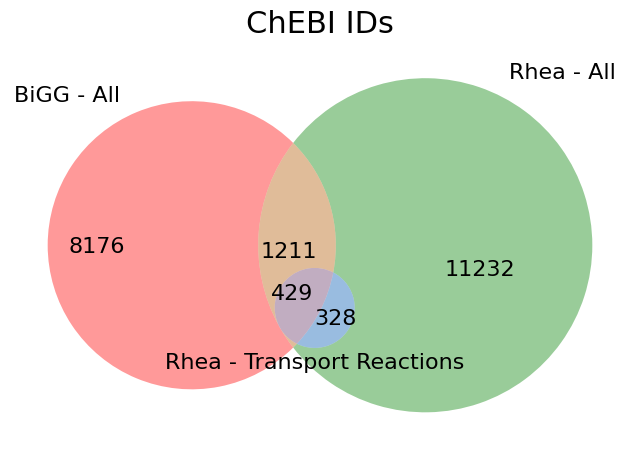

In [17]:
primary_rhea_chebi_ids = {get_primary_id(chebi_id) for chebi_id in rhea_chebi_ids_total}
primary_rhea_chebi_ids_trs = {get_primary_id(chebi_id) for chebi_id in rhea_chebi_ids_total_trs}
primary_bigg_chebi_ids = {get_primary_id(chebi_id) for chebi_id in chebis}

plt.figure(figsize=(8, 6))
venn = venn3([primary_bigg_chebi_ids, primary_rhea_chebi_ids, primary_rhea_chebi_ids_trs], ("BiGG - All", "Rhea - All", "Rhea - Transport Reactions"))
plt.title("ChEBI IDs", fontsize=22)

for label in venn.set_labels:
    label.set_fontsize(16)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(16)


plt.show()

Also a comparison on what kind of overlap this contains from the TCDB ChEBIs

In [18]:
tcdb_chebis = pd.read_csv("../tcdb_chebis.csv", usecols=[1])
tcdb_chebis['CHEBI IDs'] = tcdb_chebis['CHEBI IDs'].apply(ast.literal_eval)
tcdb_chebis_ex = tcdb_chebis.explode('CHEBI IDs')
tcdb_chebis_ex = tcdb_chebis_ex.drop_duplicates(subset='CHEBI IDs')
tcdb_chebis_ex['CHEBI IDs'] = tcdb_chebis_ex['CHEBI IDs'].apply(lambda x: f"CHEBI:{x}")
tcdb_chebis_ex = tcdb_chebis_ex.reset_index(drop=True)
tcdb_chebis_set = set(tcdb_chebis_ex["CHEBI IDs"])
primary_tcdb_chebi_ids = {get_primary_id(chebi_id) for chebi_id in tcdb_chebis_set}

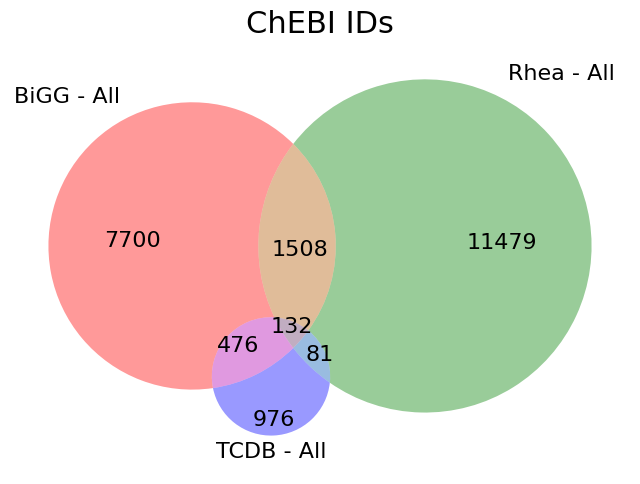

In [19]:
plt.figure(figsize=(8, 6))
venn = venn3([primary_bigg_chebi_ids, primary_rhea_chebi_ids, primary_tcdb_chebi_ids], ("BiGG - All", "Rhea - All", "TCDB - All"))
plt.title("ChEBI IDs", fontsize=22)

for label in venn.set_labels:
    label.set_fontsize(16)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(16)


plt.show()

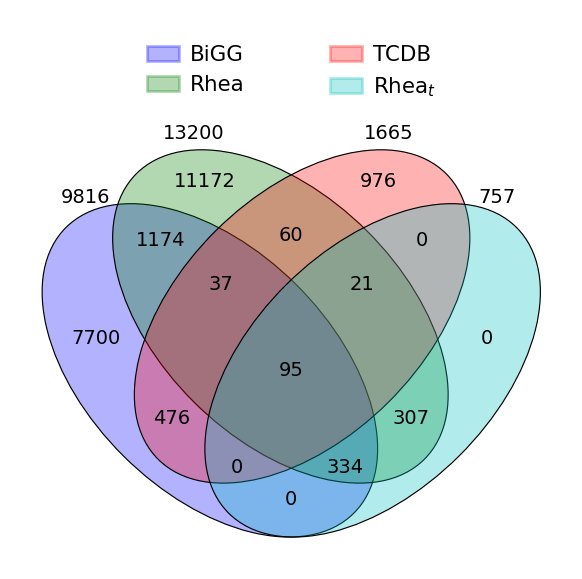

In [24]:
sets = {
    "BiGG": primary_bigg_chebi_ids,
    "Rhea": primary_rhea_chebi_ids,
    "TCDB": primary_tcdb_chebi_ids,
    "Rhea$_t$": primary_rhea_chebi_ids_trs,
}

venny4py(sets=sets)

In [31]:
chebis_tcdb_df = pd.read_csv("../tcdb_data_chebi.csv")
chebis_tcdb_df_set = set(chebis_tcdb_df["ChEBI Primary IDs"])
chebis_tcdb_df_set = {"CHEBI:" + str(chebi_id) for chebi_id in chebis_tcdb_df_set}

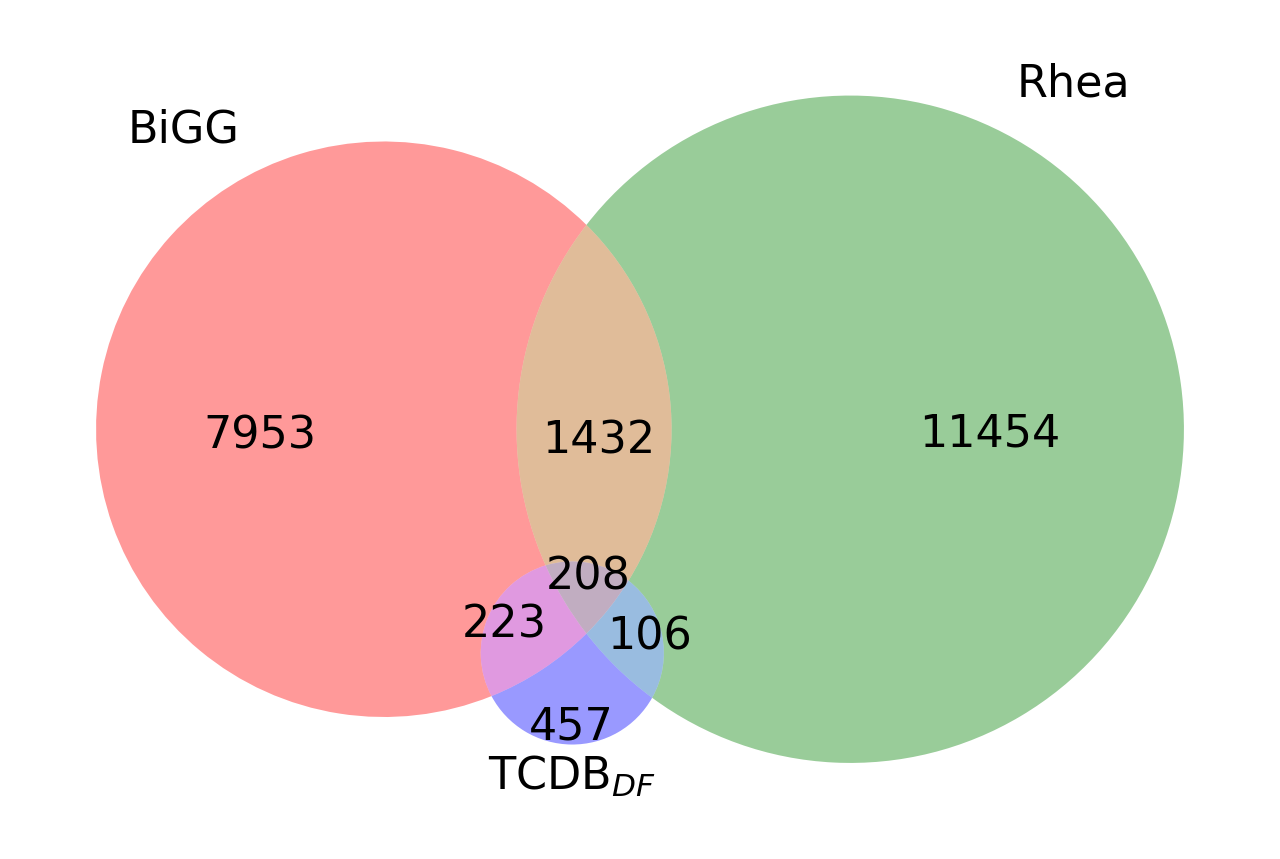

In [33]:
plt.figure(figsize=(8, 6))
venn = venn3([primary_bigg_chebi_ids, primary_rhea_chebi_ids, chebis_tcdb_df_set], ("BiGG", "Rhea", "TCDB$_{DF}$"))

for label in venn.set_labels:
    label.set_fontsize(16)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(16)


plt.show()